# Fitting Correlation Functions with `emcee`

In this demo, we provide a very simple example of how to fit galaxy correlation functions with `emcee`. This example does not do anything with the complexity required for fitting real-world data. It does not account for measurement error, or redshift evolution or redshift-space distortions. However, it gives a taste of what is achievable.

In [64]:
import emcee
import halomod
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm
from multiprocess import Pool

import corner

%matplotlib inline

In [3]:
emcee.__version__

'3.0.2'

In [6]:
halomod.__version__

'1.4.6.dev81+gfb27576.d20200728'

## Create Some Mock Data

First, let's create a default galaxy halo model:

In [51]:
model = halomod.TracerHaloModel(
    z=0.2, 
    transfer_model='EH', 
    rnum=30, 
    rmin=0.1,
    rmax=30,
    hod_model='Zehavi05', 
    hod_params={
        "M_min": 12.0,
        "M_1": 12.8,
        'alpha': 1.05
    },
    dr_table=0.1,
    dlnk=0.1,
    dlog10m=0.05
)

Now, let's create some mock data with some Gaussian noise:

In [52]:
mock_data = model.corr_auto_tracer + np.random.normal(scale = 0.2 * np.abs(model.corr_auto_tracer))

/home/steven/Documents/Projects/halos/HALOMOD/halomod/src/halomod/tools.py:527: RuntimeWarning: invalid value encountered in true_divide
  norm = self._spl(match_x) / fnc(match_x)
/home/steven/Documents/Projects/halos/HALOMOD/halomod/src/halomod/tools.py:527: RuntimeWarning: divide by zero encountered in true_divide
  norm = self._spl(match_x) / fnc(match_x)


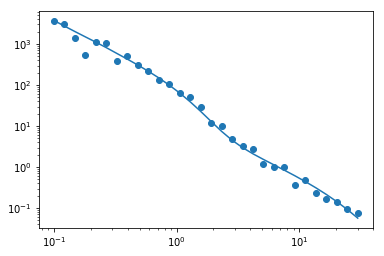

In [53]:
plt.plot(model.r, model.corr_auto_tracer)
plt.scatter(model.r, mock_data)
plt.xscale('log')
plt.yscale('log')

## Define a likelihood

Now let's define a likelihood function, based on some input model for $\xi(r)$. The model is simply a $\chi^2$ likelihood. 

In [54]:
def chi_square(model, data, sigma):
    return np.sum(norm.logpdf(data, loc=model, scale=sigma))

## Define an `emcee`-compatible likelihood function

Now we define a likelihood function for `emcee`. There is a bit more flexibility here, as this function needs to calculate priors on all input parameters, and handle exceptions as well. This means this function is rather specific to the problem at hand. We will define a very simple function, but one that is fairly general.

In [55]:
fiducial_model = model.clone()

First, we define a small utility function that will take a dictionary in which keys may be dot-paths, and converts it to a nested dictionary:

In [56]:
def flat_to_nested_dict(dct: dict) -> dict:
    """Convert a dct of key: value pairs into a nested dict.
    
    Keys that have dots in them indicate nested structure.
    """    
    def key_to_dct(key, val, dct):
        if '.' in key:
            key, parts = key.split('.', maxsplit=1)
            
            if key not in dct:
                dct[key] = {}
                
            key_to_dct(parts, val, dct[key])
        else:
            dct[key] = val
            
    out = {} 
    for k, v in dct.items():
        key_to_dct(k, v, out)

    return out

So, this will do the following:

In [57]:
flat_to_nested_dict(
    {
        'nested.key': 1,
        'nested.key2': 2,
        'non_nested': 3
        
    }
)

{'nested': {'key': 1, 'key2': 2}, 'non_nested': 3}

This will enable us to pass a list of parameter names that we want updated, which could be parameters of nested models. This means our posterior function is fairly general, and can accept any model parameters to be updated:

In [58]:
def log_prob(param_values, param_names, data, model, derived=None):
    # Update the base model with all the parameters that are being constrained.
    params = flat_to_nested_dict(dict(zip(param_names, param_values)))

    model.update(**params)
    
    if derived is not None:
        derived = [getattr(model, d) for d in derived]
    else:
        derived = []
        
    return chi_square(model.corr_auto_tracer, data, 0.2 * np.abs(model.corr_auto_tracer)), derived

We can test that the `log_prob` function works:

In [59]:
log_prob(
    [12.0, 12.8, 1.05], 
    ['hod_params.M_min', 'hod_params.M_1', 'hod_params.alpha'], 
    mock_data, 
    model, 
    derived=['satellite_fraction', 'mean_tracer_den']
)

(-86.74055220396342, [0.48966668502816935, 0.008751566584300256])

Notice the derived parameters: we can pass any `quantity` of the `TracerHaloModel`, and it will be stored on every iteration. Nice!

## Run `emcee`

Let's first run a simple model in which we just want to fit $\sigma_8$ and the spectral index $n_s$. We use the popular `emcee` package, and pass in our `log_prob` model:

In [60]:
sampler = emcee.EnsembleSampler(
    nwalkers = 30,
    ndim = 3,
    log_prob_fn = log_prob,
    kwargs = {
        'param_names': ['hod_params.M_min', 'hod_params.M_1', 'hod_params.alpha'],  
        'data': mock_data, 
        'model': model,  
        'derived': ['satellite_fraction', 'mean_tracer_den']
    },
    pool = Pool(4),
)

On the advice of the `emcee` documentation, we set up some initial positions of the walkers around the solution.

In [61]:
initialpos = np.array([
    fiducial_model.hod.params['M_min'], 
    fiducial_model.hod.params['M_1'],
    fiducial_model.hod.params['alpha']
]) + 1e-4 * np.random.normal(size=(sampler.nwalkers, sampler.ndim))

In [62]:
sampler.run_mcmc(initialpos, nsteps=500, progress='notebook');

State([[12.20288051 13.38180209  1.26246024]
 [11.36184556 11.98786548  1.04811963]
 [11.89728868 12.9146015   1.16770837]
 [11.98746931 13.02984008  1.19007677]
 [11.22543068 11.38002473  0.96186167]
 [12.24452469 13.3453963   1.22591814]
 [11.85869653 12.88869183  1.17207755]
 [11.5876731  12.34803303  1.05916742]
 [12.26387304 13.46433551  1.28504225]
 [11.92536325 12.93774881  1.16186679]
 [11.8703647  12.57987304  1.01775085]
 [11.82832438 12.55299383  1.02832696]
 [10.41582639 10.26250497  0.99416013]
 [12.11465076 13.27793302  1.28505761]
 [12.26157061 13.40210722  1.21978858]
 [11.88073672 12.69091172  1.09545853]
 [12.18049847 13.20565419  1.16507451]
 [11.70535633 12.0612918   0.9305346 ]
 [11.82988886 12.45624492  1.03042594]
 [11.73370188 12.58329312  1.10946875]
 [12.21353833 13.33684756  1.18190561]
 [11.74224168 12.47686865  1.05132231]
 [12.04317066 12.98225148  1.11992162]
 [12.21503154 13.44725011  1.31230257]
 [11.77938452 12.57980633  1.08155659]
 [12.22998389 13.37

Now we can plot the posterior in a corner plot, along with the derived parameters, and the true input values:

In [87]:
flatchain = sampler.chain[:, 200:, :].reshape((-1, 3))

flatchain = np.hstack((flatchain, sampler.blobs[200:].reshape((-1, 2))))

flatchain[:, -1] = np.log10(flatchain[:, -1])

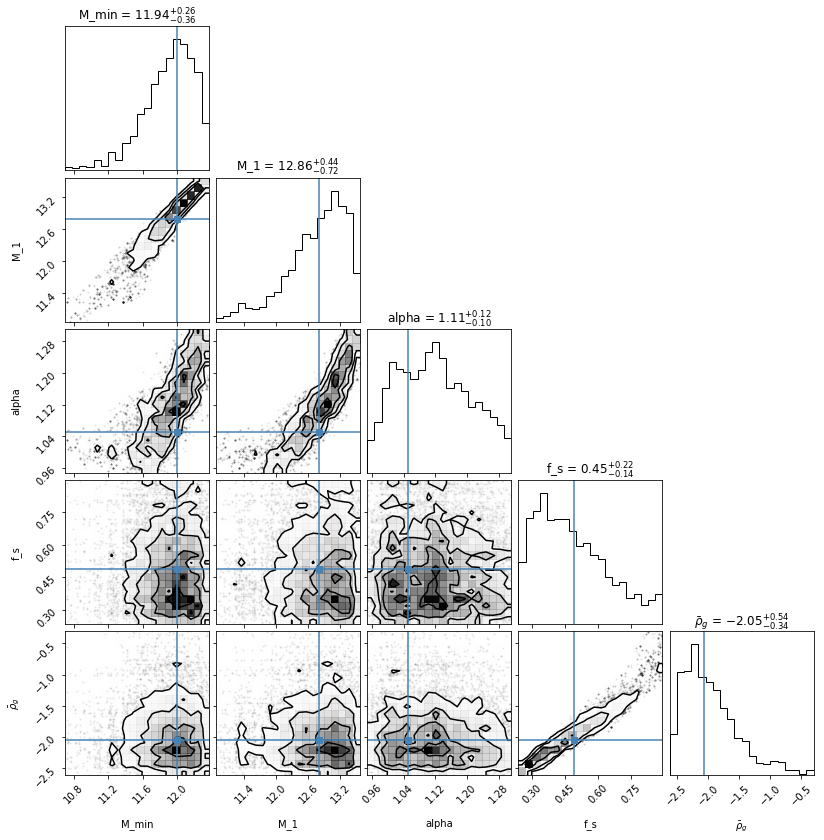

In [88]:
corner.corner(
    flatchain, 
    labels=['M_min', 'M_1', 'alpha', 'f_s', r'$\log_{10}\bar{\rho}_g$'], 
    truths=[12.0, 12.8, 1.05, fiducial_model.satellite_fraction, np.log10(fiducial_model.mean_tracer_den)], 
    show_titles=True, 
    range=[0.95, 0.95, 0.95, 0.95, 0.95]
);

And we're done! The posterior contains the truth to within 1-sigma.